In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf

from convolution_patterns.config import Config
from convolution_patterns.logger_manager import LoggerManager
from convolution_patterns.services.image_dataset_service import ImageDatasetService
from convolution_patterns.services.transform_service import TransformService

[Config] Resolved (PROJECT_ROOT): configs/transforms_used.yaml → /Users/kenneth/Public/projects/python/ai/convolution-patterns/configs/transforms_used.yaml
[Config] Resolved (PROJECT_ROOT): configs/backbones/EfficientNetB0.yaml → /Users/kenneth/Public/projects/python/ai/convolution-patterns/configs/backbones/EfficientNetB0.yaml


In [2]:
logging = LoggerManager.get_logger("class_distribution_analysis")

In [3]:
cfg = Config()
print("PROJECT ROOT:", cfg.PROJECT_ROOT)
print("BASE DIR:", cfg.BASE_DIR)
print("RAW DATA:", cfg.RAW_DATA_DIR)
print("PROCESSED DATA:", cfg.PROCESSED_DATA_DIR)
print("REPORTS DATA:", cfg.REPORTS_DIR)

PROJECT ROOT: /Users/kenneth/Public/projects/python/ai/convolution-patterns
BASE DIR: /Users/kenneth/Public/projects/python/ai/convolution-patterns/artifacts
RAW DATA: /Users/kenneth/Public/projects/python/ai/convolution-patterns/artifacts/data/raw
PROCESSED DATA: /Users/kenneth/Public/projects/python/ai/convolution-patterns/artifacts/data/processed
REPORTS DATA: /Users/kenneth/Public/projects/python/ai/convolution-patterns/artifacts/reports


In [4]:
print_stats = True
# Load transform config
path = cfg.transform_config_path
if path is None:
    raise ValueError("Transform config path must not be None.")

transform_service = TransformService.from_yaml(path)
train_pipeline = transform_service.get_pipeline(mode="train")
val_pipeline = transform_service.get_pipeline(mode="val")

# Load datasets
dataset_service = ImageDatasetService()
train_ds, train_class_names = dataset_service.get_dataset(
    "train", print_stats=print_stats, prefetch=False
)
val_ds, val_class_names = dataset_service.get_dataset(
    "val", print_stats=print_stats, prefetch=False
)

# Apply transformations
train_ds = train_ds.map(
    lambda x, y: (train_pipeline(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.map(
    lambda x, y: (val_pipeline(x), y), num_parallel_calls=tf.data.AUTOTUNE
)

Found 1807 files belonging to 11 classes.
[ 2025-06-25 08:16:13 ] INFO [../../src/convolution_patterns/services/image_dataset_service.py:64] - ❌ Excluding label(s): ['No_Pattern']
[ 2025-06-25 08:16:13 ] INFO [../../src/convolution_patterns/services/image_dataset_service.py:36] - 

📊 Dataset: train
  ➤ Image shape: (32, 224, 224, 3), dtype: <dtype: 'float32'>
  ➤ Label shape: (32, 10), dtype: <dtype: 'float32'>
  ➤ Total images: 671
  ➤ Number of batches: 21
  ➤ Number of classes (inferred): 10
  ➤ Class Names: ['CT_Downtrend', 'CT_Uptrend', 'Downtrend_Convergence', 'Downtrend_No_Convergence', 'PB_Downtrend', 'PB_Uptrend', 'Trend_Change_Bear', 'Trend_Change_Bull', 'Uptrend_Convergence', 'Uptrend_No_Convergence']
Found 193 files belonging to 11 classes.
[ 2025-06-25 08:16:14 ] INFO [../../src/convolution_patterns/services/image_dataset_service.py:64] - ❌ Excluding label(s): ['No_Pattern']
[ 2025-06-25 08:16:14 ] INFO [../../src/convolution_patterns/services/image_dataset_service.py:36] 

2025-06-25 08:16:13.985072: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-25 08:16:14.062144: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Extract images and labels from tf.data.Dataset
def dataset_to_numpy(dataset):
    images_list = []
    labels_list = []
    for batch_images, batch_labels in dataset:
        images_list.append(batch_images.numpy())
        labels_list.append(batch_labels.numpy())
    images = np.concatenate(images_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return images, labels


# train_images, train_labels_onehot = dataset_to_numpy(train_ds)
# train_labels = np.argmax(train_labels_onehot, axis=1)

# # Calculate mean pixel intensity per image
# mean_intensity = train_images.mean(axis=(1, 2, 3))

# # Create DataFrame for plotting
# df = pd.DataFrame(
#     {
#         "mean_intensity": mean_intensity,
#         "class": [train_class_names[i] for i in train_labels],
#     }
# )

# plt.figure(figsize=(14, 7))
# sns.boxplot(x="class", y="mean_intensity", data=df)
# plt.xticks(rotation=45)
# plt.title("Mean Pixel Intensity Distribution per Class")
# plt.show()

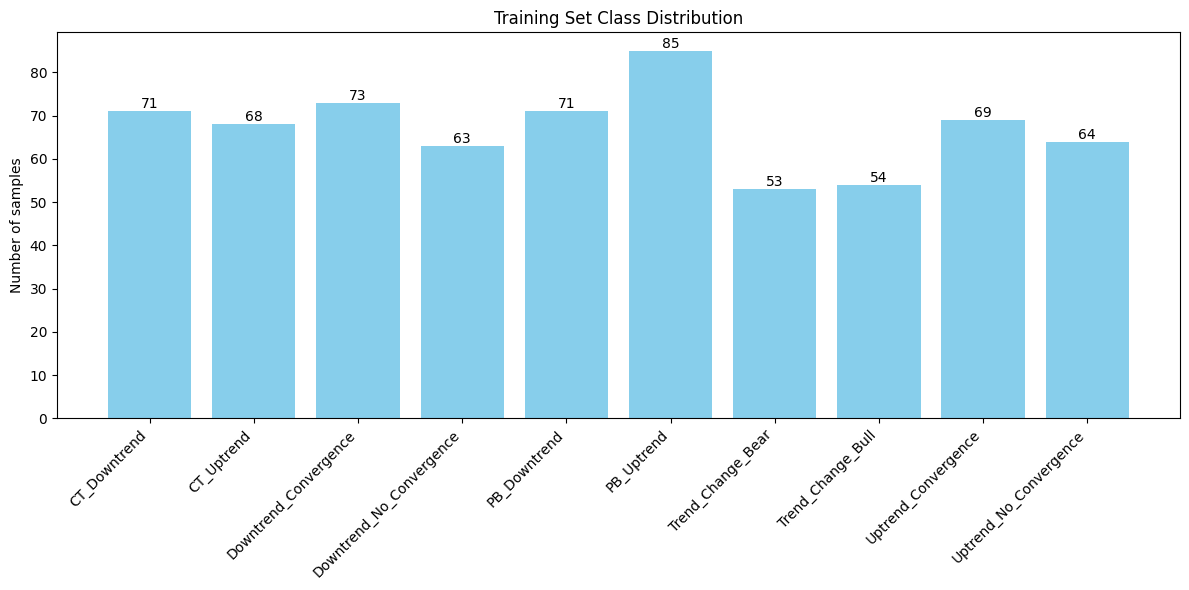

In [6]:
def get_class_distribution(labels_onehot, class_names):
    # Convert one-hot labels to class indices
    labels = np.argmax(labels_onehot, axis=1)
    counts = Counter(labels)
    distribution = {class_names[i]: counts[i] for i in range(len(class_names))}
    return distribution


def plot_class_distribution(distribution, title="Class Distribution"):
    classes = list(distribution.keys())
    counts = list(distribution.values())

    plt.figure(figsize=(12, 6))
    bars = plt.bar(classes, counts, color="skyblue")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of samples")
    plt.title(title)

    # Add counts on top of bars
    for bar, count in zip(bars, counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(count),
            ha="center",
            va="bottom",
        )
    plt.tight_layout()
    plt.show()


# Example usage with your train dataset
train_images, train_labels_onehot = dataset_to_numpy(
    train_ds
)  # Use the function from earlier
train_distribution = get_class_distribution(train_labels_onehot, train_class_names)
plot_class_distribution(train_distribution, title="Training Set Class Distribution")

# If you want to track after augmentation, do the same for augmented dataset labels
# augmented_images, augmented_labels_onehot = dataset_to_numpy(augmented_ds)
# augmented_distribution = get_class_distribution(augmented_labels_onehot, train_class_names)
# plot_class_distribution(augmented_distribution, title="Augmented Set Class Distribution")

In [7]:
for images, labels in train_ds.take(1):
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    print("Label sample:", labels[0])

Image shape: (32, 224, 224, 3)
Label shape: (32, 10)
Label sample: tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


2025-06-25 08:16:14.903979: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
